<a href="https://colab.research.google.com/github/andrealamanna/cnn_prediction_abnormalities_mammography/blob/main/BaselineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 4**
## Baseline

#Perliminar phases

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns # Grouped bar plot
import itertools
import numpy as np
import pandas as pd 
import os 
import gc # Garbage Collector
from skimage import data, img_as_float
from skimage import exposure

from tensorflow import keras
from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from keras import layers, models, regularizers, metrics
from keras.models import load_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

print("Done")

Done


In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
#PAT = 4

METRICS = [
      metrics.BinaryAccuracy(name='acc'),
]

base_path = "/content/gdrive/My Drive/Colab Notebooks/DLProject/Lamanna/"

MODEL_PATH = os.path.join(base_path, "models")
MODEL_PRETRAINED_PATH = os.path.join(MODEL_PATH, "Pretrained")
MODEL_SCRATCH_PATH = os.path.join(MODEL_PATH, "Scratch")
MODEL_BASELINE_PATH = os.path.join(MODEL_PATH, "Baseline")
PLOTS_PATH = os.path.join(base_path, "plots/Baseline")

train_img_path = os.path.join(base_path, "numpy data/train_tensor.npy")
train_label_path = os.path.join(base_path, "numpy data/train_labels.npy")
test_img_path = os.path.join(base_path, "numpy data/public_test_tensor.npy")
test_label_path = os.path.join(base_path, "numpy data/public_test_labels.npy")

print("Done")

Done


# Utility Functions

In [ ]:
# Remove baseline samples
def remove_baseline(samples): 
  max_index = int(len(samples)/2)
  indexes = [2*i + 1 for i in range(0, max_index)]

  return samples[indexes]

# Interchange the dataset index
def shuffle_dataset(i, j, k):
  indexes = tf.range(start=0, limit=tf.shape(i)[0], dtype=tf.int32)
  shuffled_indexes = tf.random.shuffle(indexes)

  i = tf.gather(i, shuffled_indexes)
  j = tf.gather(j, shuffled_indexes)
  k = tf.gather(k, shuffled_indexes)

  i = i.numpy()
  j = j.numpy()
  k = k.numpy()

  return i, j, k

# Unify masses and calcifications 
def labels_mapping_masscalc(labels):
  #labels_local = np.zeros(shape=labels.shape, dtype="float32")
  labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
      idx += 1
    # Calcifications
    if label == 3 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

# Unify mal and ben 
def labels_mapping_benmal(labels):
  labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
      idx += 1
    # Malign
    if label == 2 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

print("Done")

Done


In [ ]:
#test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
def test_model(model):
  test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_datagen.flow(test_images,
                                            test_labels,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE)#,
                                      #callbacks=[GarbageCollectorCallback()])
  print("\n---------------------------------")
  print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
  print("Loss:", "%0.2f" % (test_loss))
  #print("Precision:", "%0.2f" % (test_precision*100), "%")
  #print("Recall:", "%0.2f" % (test_recall*100), "%")
  #print("AUC:", "%0.2f" % test_auc)
  print("---------------------------------\n")

print("Done")

Done


In [ ]:
def print_opt_results(history_0):
  # History of accuracy and loss
  tra_loss_0 = history_0.history['loss']
  tra_acc_0 = history_0.history['acc']
  val_loss_0 = history_0.history['val_loss']
  val_acc_0 = history_0.history['val_acc']

  # Total number of epochs training
  epochs_0 = range(1, len(tra_acc_0)+1)
  end_epoch_0 = len(tra_acc_0)

  # Epoch when reached the val acc max
  opt_epoch_0 = val_acc_0.index(max(val_acc_0)) + 1

  # Loss and accuracy on the validation set
  end_val_loss_0 = val_loss_0[len(val_loss_0)-1]
  end_val_acc_0 = val_acc_0[len(val_acc_0)-1]
  opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
  opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

  print("Epoch [end]: %d" % end_epoch_0)
  print("Epoch [opt]: %d" % opt_epoch_0)
  print("Valid accuracy [end]: %.4f" % end_val_acc_0)
  print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
  print("Valid loss [end]: %.4f" % end_val_loss_0)
  print("Valid loss [opt]: %.4f" % opt_val_loss_0)

print("Done")

Done


In [ ]:
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  #loss = history.history['loss']
  #val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure()
  plt.plot(epochs, acc, 'b', linestyle='dashed', label='Training accuracy',color='Green')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='Blue')
  plt.title('Training and validation accuracy')
  plt.legend()
  return plt

def plot_loss(history):
  #acc = history.history['acc']
  #val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', linestyle='dashed', label='Training loss',color='cyan')
  plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
  plt.title('Training and validation loss')
  plt.legend()
  return plt

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=True):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    precision = TP / (TP + FP)

    tpr = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity
    # Visualization Data Histogram

def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=BATCH_SIZE+1,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt

print("Done")

Done


In [ ]:
#Early stop conditon 
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PAT)

In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
#class GarbageCollectorCallback(tf.keras.callbacks.Callback):
#    def on_epoch_end(self, epoch, logs=None):
#      gc.collect()

#print("Done")

In [ ]:
def earlyStop(patience):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
  return callback
print("Done")

Done


# Siamese Mass Calc


## Data operations Mass Calc

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


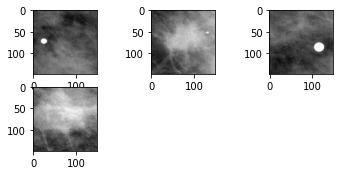

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

In [ ]:
train_baselines = np.zeros(shape=(2676, 150, 150), dtype="float32")
train_abnormalities = np.zeros(shape=(2676, 150, 150), dtype="float32")
#get even posititions
train_baselines = train_images[::2]
#get odd positions
train_abnormalities = train_images[1::2]

In [ ]:
test_baselines = np.zeros(shape=(2676, 150, 150), dtype="float32")
test_abnormalities = np.zeros(shape=(2676, 150, 150), dtype="float32")
#get even posititions
test_baselines = test_images[::2]
#get odd positions
test_abnormalities = test_images[1::2]

In [ ]:
print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
# Mapping labels with standard index
train_labels = labels_mapping_masscalc(train_labels)
test_labels = labels_mapping_masscalc(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1218 1458]
[0. 1.] [179 157]


In [ ]:
# Suffle index (Previous dataset is ordered by index)
train_abnormalities, train_labels, train_baselines = shuffle_dataset(train_abnormalities, train_labels, train_baselines)
test_abnormalities, test_labels, test_baselines = shuffle_dataset(test_abnormalities, test_labels, test_baselines)

In [ ]:
train_baselines = train_baselines.reshape(train_baselines.shape + (1,)) #(2676, 150, 150, 1)
train_abnormalities = train_abnormalities.reshape(train_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_abnormalities = test_abnormalities.reshape(test_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_baselines = test_baselines.reshape(test_baselines.shape + (1,)) #(2676, 150, 150, 1)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train baselines shape:  (2676, 150, 150, 1)
Train abnormalities shape:  (2676, 150, 150, 1)
Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
#reshape to expand grayscale to rgb
train_baselines = np.repeat(train_baselines, 3, axis = 3)
train_abnormalities = np.repeat(train_abnormalities, 3, axis = 3)
test_abnormalities = np.repeat(test_abnormalities, 3, axis = 3)
test_baselines = np.repeat(test_baselines, 3, axis = 3)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train baselines shape:  (2676, 150, 150, 3)
Train abnormalities shape:  (2676, 150, 150, 3)
Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_abnormalities))
train_datasetabn_split = train_abnormalities[:split_index]
valid_datasetabn_split = train_abnormalities[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]
train_datasetbase_split = train_baselines[:split_index]
valid_datasetbase_split = train_baselines[split_index:]

print(train_datasetabn_split.shape)
print(valid_datasetabn_split.shape)
print(train_datasetbase_split.shape)
print(valid_datasetbase_split.shape)

(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140, 150, 150, 3)
(536, 150, 150, 3)


In [ ]:
def generator(train_abnorm_images, train_base_images, train_labels, batch_size=128):

  image_gen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest')

  image_gen.fit(train_abnorm_images)

  gen_abnorm = image_gen.flow(train_abnorm_images, train_labels,  batch_size=batch_size, shuffle=True)
  gen_base = image_gen.flow(train_base_images, train_labels, batch_size=batch_size, shuffle=True)

  while True:
    abn_img, abn_label = gen_abnorm.next()
    base_img, _ = gen_base.next()
    yield [abn_img, base_img], abn_label

train_generator = generator(train_datasetabn_split, train_datasetbase_split, train_labels_split, batch_size=128)
validation_generator = generator(valid_datasetabn_split, valid_datasetbase_split, valid_labels_split, batch_size=128)
test_generator = generator(test_abnormalities, test_baselines, test_labels, batch_size=128)

In [ ]:
# All images will be rescaled by 1./65535 (max value range)
#train_datagen = ImageDataGenerator(rescale=1./65535)
#valid_datagen = ImageDataGenerator(rescale=1./65535)
#test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
#train_datagen = ImageDataGenerator(
#    rescale=1./65535,
#    rotation_range=40,
#    width_shift_range=0.25,
#    height_shift_range=0.25,
#    shear_range=0.5,
#    zoom_range=0.5, #0.5 - 1.5
#    horizontal_flip=True,
#    fill_mode='nearest')

##Model 6.3 Pretrained

In [ ]:
from keras.models import Model
from tensorflow.keras.utils import plot_model

INPUT_SHAPE = (150, 150, 3)
MODEL_PATH = os.path.join(base_path, "models/Pretrained/")

def create_siamese(CNN_core):

  pretrained = models.load_model(os.path.join(MODEL_PATH, CNN_core))
  
  pretrained.trainable = False

  x = pretrained.layers[-2].output
  output = layers.Dense(512, activation='relu', name='extractor')(x)
  cnn = Model(pretrained.input, output)

  # Feed both input into the same convolutional base
  left_input = layers.Input(shape=INPUT_SHAPE)
  right_input = layers.Input(shape=INPUT_SHAPE)

  left_model = cnn(left_input)
  right_model = cnn(right_input)

  # Compute the difference between the two
  L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([left_model, right_model])

  # FC layer
  # Add a dense layer with a sigmoid unit to generate the prediction
  prediction = layers.Dense(1, activation='sigmoid')(L1_distance)

  # Instantiate the model
  siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)

  return siamese

In [ ]:
callback=earlyStop(25)

In [ ]:
BATCH_SIZE=128

In [ ]:
# Instantiate model
siamese = create_siamese('calcmasses_inceptionv3_model63.h5')
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 512)          31503136    ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [ ]:
siamese.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(learning_rate=1e-4),
            metrics=['acc']) 

In [ ]:
history = siamese.fit(
        train_generator,
        steps_per_epoch=len(train_datasetabn_split) // BATCH_SIZE,
        epochs=100,
        validation_data=validation_generator,
        validation_steps = len(valid_datasetabn_split) // BATCH_SIZE,
        callbacks=[callback],
        shuffle=True,
        verbose=1)

Epoch 1/100
16/16 [==============================] - 70s 3s/step - loss: 0.6373 - acc: 0.6353 - val_loss: 0.5542 - val_acc: 0.7773
Epoch 2/100
16/16 [==============================] - 50s 3s/step - loss: 0.5406 - acc: 0.7580 - val_loss: 0.5121 - val_acc: 0.7793
Epoch 3/100
16/16 [==============================] - 35s 2s/step - loss: 0.5147 - acc: 0.7644 - val_loss: 0.4848 - val_acc: 0.7910
Epoch 4/100
16/16 [==============================] - 32s 2s/step - loss: 0.4785 - acc: 0.7808 - val_loss: 0.4497 - val_acc: 0.7852
Epoch 5/100
16/16 [==============================] - 30s 2s/step - loss: 0.4758 - acc: 0.7922 - val_loss: 0.4159 - val_acc: 0.8262
Epoch 6/100
16/16 [==============================] - 30s 2s/step - loss: 0.4484 - acc: 0.7987 - val_loss: 0.4341 - val_acc: 0.8066
Epoch 7/100
16/16 [==============================] - 30s 2s/step - loss: 0.4623 - acc: 0.7883 - val_loss: 0.4261 - val_acc: 0.8086
Epoch 8/100
16/16 [==============================] - 31s 2s/step - loss: 0.4489 - a

In [ ]:
siamese.save(os.path.join(base_path,'models/Baseline/calcmasses_model1.h5'))

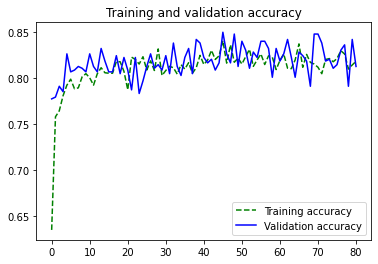

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'Baselines/model1_acc.png'))
plt_a.show()

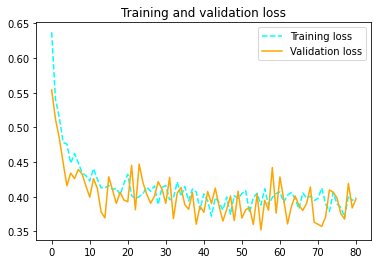

In [ ]:
plt_a = plot_loss(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'Baselines/model1_loss.png'))
plt_a.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 81
Epoch [opt]: 46
Valid accuracy [end]: 0.8125
Valid accuracy [opt]: 0.8496
Valid loss [end]: 0.3971
Valid loss [opt]: 0.3648


In [ ]:
test_loss, test_accuracy = siamese.evaluate(test_generator, steps=int(0.8*2676) // 128)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss))
print("---------------------------------\n")

16/16 [==============================] - 22s 1s/step - loss: 0.4188 - acc: 0.7992

---------------------------------
Accuracy: 79.92 %
Loss: 0.42
---------------------------------



In [ ]:
#test_model(siamese)

In [ ]:
model_best=siamese

In [ ]:
model_best=load_model(os.path.join(base_path, "models/Baseline/calcmasses_model1.h5"))

In [ ]:
print(test_images.shape)

(672, 150, 150)


(336,)
(672, 150, 150)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.54      0.51      0.52       179
         1.0       0.48      0.51      0.49       157

    accuracy                           0.51       336
   macro avg       0.51      0.51      0.51       336
weighted avg       0.51      0.51      0.51       336



Text(0.5, -6.819805153394636, 'Predicted label')

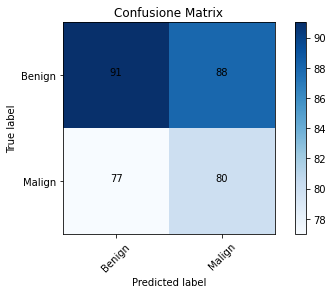

In [ ]:
classes = ["Benign", "Malign"]
#Y_pred = model_best.predict(test_images,
#                            test_labels,
#                            batch_size=BATCH_SIZE+2,
#                            shuffle=False),
#                            steps=int(336//128+1))
Y_pred = model_best.predict(test_generator,steps=int(336//128+1))#steps=int(336//128+1))

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")
        #color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

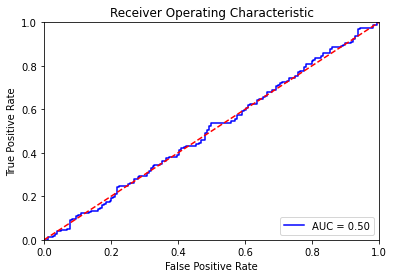

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model 2 Scratch

In [ ]:
from keras.models import Model
from tensorflow.keras.utils import plot_model

INPUT_SHAPE = (150, 150, 1)
MODEL_PATH = os.path.join(base_path, "models/Scratch/")

def create_siamese(CNN_core):

  pretrained = models.load_model(os.path.join(MODEL_PATH, CNN_core))
  
  pretrained.trainable = False

  x = pretrained.layers[-2].output
  output = layers.Dense(128, activation='relu', name='extractor')(x)
  cnn = Model(pretrained.input, output)

  # Feed both input into the same convolutional base
  left_input = layers.Input(shape=INPUT_SHAPE)
  right_input = layers.Input(shape=INPUT_SHAPE)

  left_model = cnn(left_input)
  right_model = cnn(right_input)

  # Compute the difference between the two
  L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([left_model, right_model])

  # FC layer
  # Add a dense layer with a sigmoid unit to generate the prediction
  prediction = layers.Dense(1, activation='sigmoid')(L1_distance)

  # Instantiate the model
  siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)

  return siamese

In [ ]:
callback=earlyStop(25)

In [ ]:
BATCH_SIZE=64

In [ ]:
siamese = create_siamese('calcmasses_model4.h5')
siamese.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_16 (InputLayer)          [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_11 (Functional)          (None, 128)          19049216    ['input_15[0][0]',               
                                                                  'input_16[0][0]']        

In [ ]:
siamese.compile(loss="binary_crossentropy",
            optimizer='rmsprop',
            metrics=['acc']) 

In [ ]:
history = siamese.fit(
        train_generator,
        steps_per_epoch=len(train_datasetabn_split) // BATCH_SIZE,
        epochs=100,
        validation_data=validation_generator,
        validation_steps = len(valid_datasetabn_split) // BATCH_SIZE,
        callbacks=[callback],
        shuffle=True,
        verbose=1)

Epoch 1/100
33/33 [==============================] - 21s 640ms/step - loss: 0.5779 - acc: 0.7021 - val_loss: 0.4850 - val_acc: 0.7957
Epoch 2/100
33/33 [==============================] - 20s 625ms/step - loss: 0.5119 - acc: 0.7637 - val_loss: 0.4914 - val_acc: 0.7831
Epoch 3/100
33/33 [==============================] - 20s 629ms/step - loss: 0.4747 - acc: 0.7835 - val_loss: 0.5114 - val_acc: 0.7684
Epoch 4/100
33/33 [==============================] - 20s 620ms/step - loss: 0.4834 - acc: 0.7818 - val_loss: 0.5698 - val_acc: 0.7488
Epoch 5/100
33/33 [==============================] - 20s 634ms/step - loss: 0.4645 - acc: 0.7938 - val_loss: 0.4652 - val_acc: 0.7935
Epoch 6/100
33/33 [==============================] - 21s 637ms/step - loss: 0.4745 - acc: 0.7813 - val_loss: 0.4787 - val_acc: 0.7913
Epoch 7/100
33/33 [==============================] - 20s 622ms/step - loss: 0.4703 - acc: 0.7806 - val_loss: 0.4620 - val_acc: 0.7855
Epoch 8/100
33/33 [==============================] - 20s 621ms

In [ ]:
siamese.save(os.path.join(base_path,'models/Baseline/calcmasses_model2.h5'))

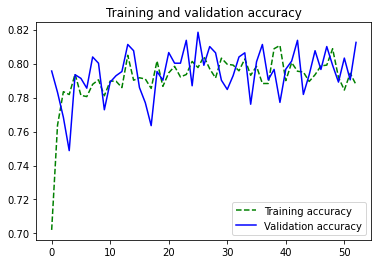

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

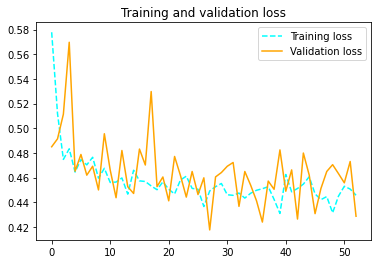

In [ ]:
plt_a = plot_loss(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 53
Epoch [opt]: 26
Valid accuracy [end]: 0.8125
Valid accuracy [opt]: 0.8185
Valid loss [end]: 0.4286
Valid loss [opt]: 0.4462


In [ ]:
test_loss, test_accuracy = siamese.evaluate(test_generator, steps=int(0.8*2676) // 128)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss))
print("Precision:", "%0.2f" % (test_precision*100), "%")
print("Recall:", "%0.2f" % (test_recall*100), "%")
print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")


16/16 [==============================] - 7s 449ms/step - loss: 0.4574 - acc: 0.7826

---------------------------------
Accuracy: 78.26 %
Loss: 0.46
Precision: 77.26 %
Recall: 82.74 %
AUC: 0.89
---------------------------------



In [ ]:
#test_model(siamese)

In [ ]:
model_best=siamese

(336,)
(672, 150, 150)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51       179
         1.0       0.45      0.47      0.46       157

    accuracy                           0.49       336
   macro avg       0.49      0.49      0.49       336
weighted avg       0.49      0.49      0.49       336



Text(0.5, -6.819805153394636, 'Predicted label')

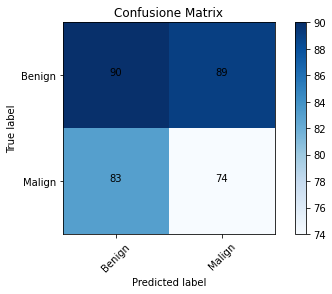

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_generator, steps=int(336//128+1))

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

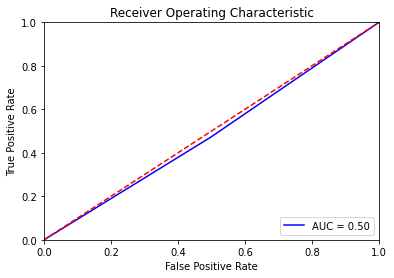

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Siamese Ben Mal


## Data operations Ben Mal

In [ ]:
train_images = np.load(train_img_path)
train_labels = np.load(train_label_path)
test_images = np.load(test_img_path)
test_labels = np.load(test_label_path)

#count quantity masses and calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)
print("Train dataset")
print("---------------------------------")
print("Masses: \t\t", counts[1]+counts[2])
print("Calcification: \t\t", counts[3]+counts[4])
print("---------------------------------")
print("Benign: \t\t", counts[1]+counts[3])
print("Malign: \t\t", counts[2]+counts[4])
print("---------------------------------")
print("Benign Masses: \t\t", counts[1])
print("Malign Masses: \t\t", counts[2])
print("Benign Calcification: \t", counts[3])
print("Malign Calcification: \t", counts[4])
print("---------------------------------")
print("Baseline: \t\t", counts[0])
print("---------------------------------")
print("Total: \t\t\t", counts[0]+counts[1]+counts[2]+counts[3]+counts[4])

#count quantity masses and calcifications
uniqueT, countsT = np.unique(test_labels, return_counts=True)
#print(unique, countsT)
print("\n")
print("Test dataset")
print("---------------------------------")
print("Masses: \t\t", countsT[1]+countsT[2])
print("Calcification: \t\t", countsT[3]+countsT[4])
print("---------------------------------")
print("Benign: \t\t", countsT[1]+countsT[3])
print("Malign: \t\t", countsT[2]+countsT[4])
print("---------------------------------")
print("Benign Masses: \t\t", countsT[1])
print("Malign Masses: \t\t", countsT[2])
print("Benign Calcification: \t", countsT[3])
print("Malign Calcification: \t", countsT[4])
print("---------------------------------")
print("Baseline: \t\t", countsT[0])
print("---------------------------------")
print("Total: \t\t\t", countsT[0]+countsT[1]+countsT[2]+countsT[3]+countsT[4])

Train dataset
---------------------------------
Masses: 		 1218
Calcification: 		 1458
---------------------------------
Benign: 		 1568
Malign: 		 1108
---------------------------------
Benign Masses: 		 620
Malign Masses: 		 598
Benign Calcification: 	 948
Malign Calcification: 	 510
---------------------------------
Baseline: 		 2676
---------------------------------
Total: 			 5352


Test dataset
---------------------------------
Masses: 		 179
Calcification: 		 157
---------------------------------
Benign: 		 219
Malign: 		 117
---------------------------------
Benign Masses: 		 113
Malign Masses: 		 66
Benign Calcification: 	 106
Malign Calcification: 	 51
---------------------------------
Baseline: 		 336
---------------------------------
Total: 			 672


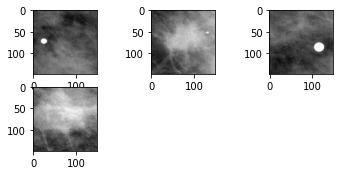

In [ ]:
images = range(0,4)
for i in images:
    plt.subplot(330 + 1 + i)
    plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
    
#Show the plot
plt.show()

In [ ]:
train_baselines = np.zeros(shape=(2676, 150, 150), dtype="float32")
train_abnormalities = np.zeros(shape=(2676, 150, 150), dtype="float32")
#get even posititions
train_baselines = train_images[::2]
#get odd positions
train_abnormalities = train_images[1::2]

In [ ]:
test_baselines = np.zeros(shape=(2676, 150, 150), dtype="float32")
test_abnormalities = np.zeros(shape=(2676, 150, 150), dtype="float32")
#get even posititions
test_baselines = test_images[::2]
#get odd positions
test_abnormalities = test_images[1::2]

In [ ]:
print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
# Mapping labels with standard index
train_labels = labels_mapping_benmal(train_labels)
test_labels = labels_mapping_benmal(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(unique, counts)
unique, counts = np.unique(test_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1568 1108]
[0. 1.] [219 117]


In [ ]:
# Suffle index (Previous dataset is ordered by index)
train_abnormalities, train_labels, train_baselines = shuffle_dataset(train_abnormalities, train_labels, train_baselines)
test_abnormalities, test_labels, test_baselines = shuffle_dataset(test_abnormalities, test_labels, test_baselines)

In [ ]:
train_baselines = train_baselines.reshape(train_baselines.shape + (1,)) #(2676, 150, 150, 1)
train_abnormalities = train_abnormalities.reshape(train_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_abnormalities = test_abnormalities.reshape(test_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
test_baselines = test_baselines.reshape(test_baselines.shape + (1,)) #(2676, 150, 150, 1)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train baselines shape:  (2676, 150, 150, 1)
Train abnormalities shape:  (2676, 150, 150, 1)
Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
#reshape to expand grayscale to rgb
train_baselines = np.repeat(train_baselines, 3, axis = 3)
train_abnormalities = np.repeat(train_abnormalities, 3, axis = 3)
test_abnormalities = np.repeat(test_abnormalities, 3, axis = 3)
test_baselines = np.repeat(test_baselines, 3, axis = 3)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train baselines shape:  (2676, 150, 150, 3)
Train abnormalities shape:  (2676, 150, 150, 3)
Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
#Splitting training-validation with 80-20 %
split_index = int(0.8*len(train_abnormalities))
train_datasetabn_split = train_abnormalities[:split_index]
valid_datasetabn_split = train_abnormalities[split_index:]
train_labels_split = train_labels[:split_index]
valid_labels_split = train_labels[split_index:]
train_datasetbase_split = train_baselines[:split_index]
valid_datasetbase_split = train_baselines[split_index:]

print(train_datasetabn_split.shape)
print(valid_datasetabn_split.shape)
print(train_datasetbase_split.shape)
print(valid_datasetbase_split.shape)

(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140, 150, 150, 3)
(536, 150, 150, 3)


In [ ]:
def generator(train_abnorm_images, train_base_images, train_labels, batch_size=128):

  image_gen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.5,
    zoom_range=0.5, #0.5 - 1.5
    horizontal_flip=True,
    fill_mode='nearest')

  image_gen.fit(train_abnorm_images)

  gen_abnorm = image_gen.flow(train_abnorm_images, train_labels,  batch_size=batch_size, shuffle=True)
  gen_base = image_gen.flow(train_base_images, train_labels, batch_size=batch_size, shuffle=True)

  while True:
    abn_img, abn_label = gen_abnorm.next()
    base_img, _ = gen_base.next()
    yield [abn_img, base_img], abn_label

train_generator = generator(train_datasetabn_split, train_datasetbase_split, train_labels_split, batch_size=128)
validation_generator = generator(valid_datasetabn_split, valid_datasetbase_split, valid_labels_split, batch_size=128)
test_generator = generator(test_abnormalities, test_baselines, test_labels, batch_size=128)

In [ ]:
# All images will be rescaled by 1./65535 (max value range)
#train_datagen = ImageDataGenerator(rescale=1./65535)
#valid_datagen = ImageDataGenerator(rescale=1./65535)
#test_datagen = ImageDataGenerator(rescale=1./65535)

In [ ]:
# Train data augmentation. Deep Convolutional Neural Networks for breast cancer screening. Hiba Chougrada, Hamid Zouaki, Omar Alheyane b
#train_datagen = ImageDataGenerator(
#    rescale=1./65535,
#    rotation_range=40,
#    width_shift_range=0.25,
#    height_shift_range=0.25,
#    shear_range=0.5,
#    zoom_range=0.5, #0.5 - 1.5
#    horizontal_flip=True,
#    fill_mode='nearest')

##Model best Scratch

In [ ]:
from keras.models import Model
from tensorflow.keras.utils import plot_model

INPUT_SHAPE = (150, 150, 1)

pretrained = models.load_model(os.path.join(MODEL_SCRATCH_PATH, 'benmal_modelbest.h5'))
  
pretrained.trainable = False

x = pretrained.layers[-2].output
output = layers.Dense(512, activation='relu', name='extractor')(x)
cnn = Model(pretrained.input, output)

# Feed both input into the same convolutional base
left_input = layers.Input(shape=INPUT_SHAPE)
right_input = layers.Input(shape=INPUT_SHAPE)

left_model = cnn(left_input)
right_model = cnn(right_input)

# Compute the difference between the two
L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([left_model, right_model])

# FC layer
# Add a dense layer with a sigmoid unit to generate the prediction
prediction = layers.Dense(1, activation='sigmoid')(L1_distance)

# Instantiate the model
siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)

siamese.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 512)          4107584     ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [ ]:
siamese.compile(loss="binary_crossentropy",
            optimizer='rmsprop',
            metrics=['acc']) 

In [ ]:
BATCH_SIZE=128

In [ ]:
callback=earlyStop(25)

In [ ]:
history = siamese.fit(
        train_generator,
        steps_per_epoch=len(train_datasetabn_split) // BATCH_SIZE,
        epochs=100,
        validation_data=validation_generator,
        validation_steps = len(valid_datasetabn_split) // BATCH_SIZE,
        callbacks=[callback],
        shuffle=True,
        verbose=1)

Epoch 1/100
16/16 [==============================] - 27s 1s/step - loss: 0.6631 - acc: 0.5933 - val_loss: 0.6152 - val_acc: 0.6074
Epoch 2/100
16/16 [==============================] - 11s 678ms/step - loss: 0.6421 - acc: 0.6103 - val_loss: 0.6115 - val_acc: 0.6523
Epoch 3/100
16/16 [==============================] - 11s 730ms/step - loss: 0.6384 - acc: 0.6029 - val_loss: 0.6071 - val_acc: 0.6309
Epoch 4/100
16/16 [==============================] - 8s 537ms/step - loss: 0.6531 - acc: 0.6128 - val_loss: 0.6190 - val_acc: 0.6562
Epoch 5/100
16/16 [==============================] - 8s 536ms/step - loss: 0.6371 - acc: 0.6133 - val_loss: 0.6076 - val_acc: 0.6426
Epoch 6/100
16/16 [==============================] - 8s 535ms/step - loss: 0.6373 - acc: 0.6198 - val_loss: 0.6123 - val_acc: 0.6250
Epoch 7/100
16/16 [==============================] - 8s 538ms/step - loss: 0.6273 - acc: 0.6272 - val_loss: 0.6129 - val_acc: 0.6328
Epoch 8/100
16/16 [==============================] - 9s 585ms/step - 

In [ ]:
siamese.save(os.path.join(MODEL_BASELINE_PATH,'baseline_model3.h5'))

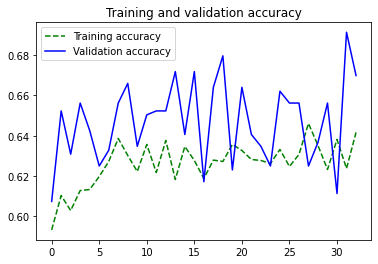

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_acc_3.png'))
plt_a.show()

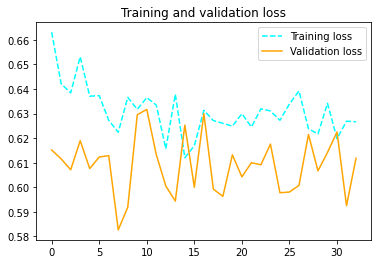

In [ ]:
plt_a = plot_loss(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_loss_3.png'))
plt_a.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 33
Epoch [opt]: 32
Valid accuracy [end]: 0.6699
Valid accuracy [opt]: 0.6914
Valid loss [end]: 0.6119
Valid loss [opt]: 0.5925


In [ ]:
test_loss, test_accuracy = siamese.evaluate(test_generator, steps=int(0.8*2676) // 128)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss))
print("---------------------------------\n")

16/16 [==============================] - 6s 410ms/step - loss: 0.6628 - acc: 0.5973

---------------------------------
Accuracy: 59.73 %
Loss: 0.66
---------------------------------



In [ ]:
#test_model(siamese)

In [ ]:
model_best=siamese

In [ ]:
model_best=load_model(os.path.join(base_path, "models/Baseline/calcmasses_model1.h5"))

In [ ]:
print(test_images.shape)

(672, 150, 150)


(336,)
(672, 150, 150)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.64      0.47      0.54       219
         1.0       0.33      0.50      0.40       117

    accuracy                           0.48       336
   macro avg       0.48      0.48      0.47       336
weighted avg       0.53      0.48      0.49       336



Text(0.5, -6.819805153394636, 'Predicted label')

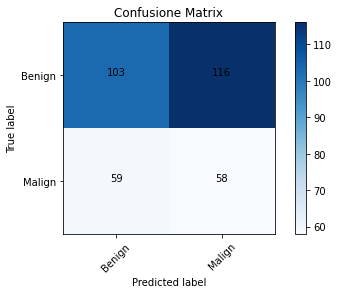

In [ ]:
classes = ["Benign", "Malign"]
#Y_pred = model_best.predict(test_images,
#                            test_labels,
#                            batch_size=BATCH_SIZE+2,
#                            shuffle=False),
#                            steps=int(336//128+1))
Y_pred = model_best.predict(test_generator,steps=int(336//128+1))#steps=int(336//128+1))

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")
        #color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

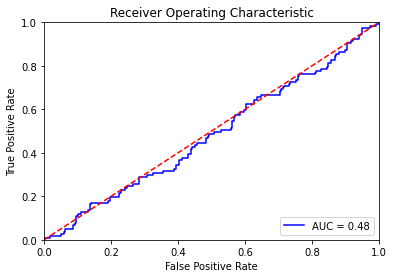

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Model 9 Pretrained

In [ ]:
from keras.models import Model
from tensorflow.keras.utils import plot_model

INPUT_SHAPE = (150, 150, 3)

pretrained = models.load_model(os.path.join(MODEL_PRETRAINED_PATH, 'benmal_inceptionv3_model9.h5'))
  
pretrained.trainable = False

x = pretrained.layers[-2].output
output = layers.Dense(128, activation='relu', name='extractor')(x)
cnn = Model(pretrained.input, output)

# Feed both input into the same convolutional base
left_input = layers.Input(shape=INPUT_SHAPE)
right_input = layers.Input(shape=INPUT_SHAPE)

left_model = cnn(left_input)
right_model = cnn(right_input)

# Compute the difference between the two
L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([left_model, right_model])

# FC layer
# Add a dense layer with a sigmoid unit to generate the prediction
prediction = layers.Dense(1, activation='sigmoid')(L1_distance)

# Instantiate the model
siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)

siamese.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           (None, 128)          24178720    ['input_11[0][0]',               
                                                                  'input_12[0][0]']         

In [ ]:
callback=earlyStop(25)

In [ ]:
BATCH_SIZE=64

In [ ]:
siamese.compile(loss="binary_crossentropy",
            optimizer=optimizers.RMSprop(learning_rate=1e-3),
            metrics=['acc']) 

In [ ]:
history = siamese.fit(
        train_generator,
        steps_per_epoch=len(train_datasetabn_split) // BATCH_SIZE,
        epochs=100,
        validation_data=validation_generator,
        validation_steps = len(valid_datasetabn_split) // BATCH_SIZE,
        callbacks=[callback],
        shuffle=True,
        verbose=1)

Epoch 1/100
33/33 [==============================] - 82s 2s/step - loss: 1.4129 - acc: 0.5907 - val_loss: 0.8681 - val_acc: 0.6228
Epoch 2/100
33/33 [==============================] - 64s 2s/step - loss: 0.8983 - acc: 0.6392 - val_loss: 0.8314 - val_acc: 0.6311
Epoch 3/100
33/33 [==============================] - 55s 2s/step - loss: 0.8334 - acc: 0.6351 - val_loss: 0.7456 - val_acc: 0.6458
Epoch 4/100
33/33 [==============================] - 47s 1s/step - loss: 0.8239 - acc: 0.6443 - val_loss: 0.6952 - val_acc: 0.6569
Epoch 5/100
33/33 [==============================] - 53s 2s/step - loss: 0.8445 - acc: 0.6440 - val_loss: 0.7866 - val_acc: 0.6326
Epoch 6/100
33/33 [==============================] - 48s 1s/step - loss: 0.7586 - acc: 0.6431 - val_loss: 0.6763 - val_acc: 0.6826
Epoch 7/100
33/33 [==============================] - 47s 1s/step - loss: 0.7579 - acc: 0.6537 - val_loss: 0.6842 - val_acc: 0.6532
Epoch 8/100
33/33 [==============================] - 47s 1s/step - loss: 0.7626 - a

In [ ]:
siamese.save(os.path.join(MODEL_BASELINE_PATH,'benmal_model4.h5'))

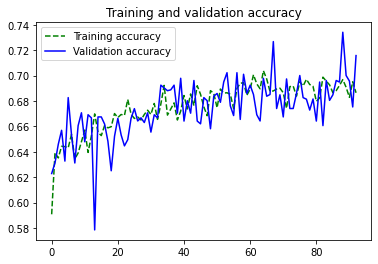

In [ ]:
plt_a = plot_acc(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_acc_4.png'))
plt_a.show()

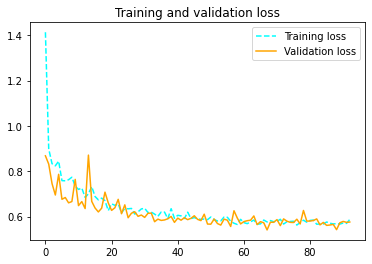

In [ ]:
plt_a = plot_loss(history)
plt_a.savefig(os.path.join(PLOTS_PATH, 'benmal_prec_4.png'))
plt_a.show()

In [ ]:
print_opt_results(history)

Epoch [end]: 93
Epoch [opt]: 89
Valid accuracy [end]: 0.7157
Valid accuracy [opt]: 0.7341
Valid loss [end]: 0.5762
Valid loss [opt]: 0.5423


In [ ]:
test_loss, test_accuracy = siamese.evaluate(test_generator, steps=int(0.8*2676) // 128)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
print("Loss:", "%0.2f" % (test_loss))
print("---------------------------------\n")

16/16 [==============================] - 18s 1s/step - loss: 0.6105 - acc: 0.6659

---------------------------------
Accuracy: 66.59 %
Loss: 0.61
---------------------------------



In [ ]:
#test_model(siamese)

In [ ]:
model_best=siamese

(336,)
(672, 150, 150)
(336, 1)
(336, 1)
Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.63      0.61      0.62       219
         1.0       0.31      0.33      0.32       117

    accuracy                           0.51       336
   macro avg       0.47      0.47      0.47       336
weighted avg       0.52      0.51      0.52       336



Text(0.5, -6.819805153394636, 'Predicted label')

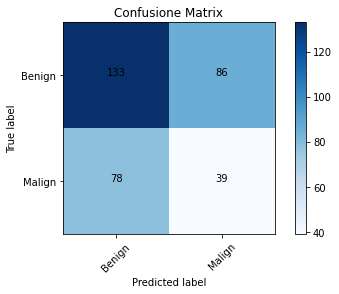

In [ ]:
classes = ["Benign", "Malign"]
Y_pred = model_best.predict(test_generator, steps=int(336//128+1))

y_pred = np.where(Y_pred < 0.5, 0, 1)

print(test_labels.shape)
print(test_images.shape)
print(Y_pred.shape)
print(y_pred.shape)

print('Confusion Matrix')
cm = confusion_matrix(test_labels, y_pred)

#print(cm)
#print('Classification Report')
print(classification_report(test_labels, y_pred))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusione Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

#print(cm)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        #color="white" if cm[i, j] > thresh else "black")
        color="black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


In [ ]:
fpr,tpr,th = roc_curve(test_labels, Y_pred)

roc_auc = roc_auc_score(test_labels, Y_pred)

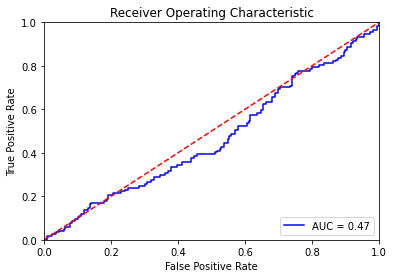

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()